In [261]:
import numpy as np
from numpy import array

import random
from random import randint
import os

import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD

In [262]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [263]:
              """Hyperparameters"""
w = 17280-500                 # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 5000                # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w        # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

In [264]:
from hdf_helper import *
from stat_helper import *
from data_cleaning import *

import h5py

In [265]:
#df = pd.read_csv('data/datch_3.csv').drop(['Unnamed: 0'], axis = 1)

path = 'dat/cleaned_dat/ch_27.csv.csv'
df_test = pd.read_csv(path, nrows=100)

float_cols = [c for i, c in enumerate(df_test.columns) if i != 0]
float64_cols = {c: np.float64 for c in float_cols}

df = pd.read_csv(path, engine='c', dtype=float64_cols).drop(['Unnamed: 0'], axis = 1)
df = df.replace(np.NAN, 0.0)

zero_outliers = df.loc[:, (df == 0.0).all(axis=0)]
reg_data = df.loc[:,(df != 0.0).any(axis=0)]

#df = reduce_dataset_size(df, cluster_size = 50)
df = smooth_values(df)
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df))


In [266]:
w = len(df.index) - p_w

In [267]:
"""
Data preprocessing


"""
# split a univariate sequence into samples
def split_sequence(sequence):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + w
        out_end_ix = end_ix + p_w
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [268]:
# # define input sequence
# for col in reg_data.columns:
#     sampl, labl = split_sequence(list(reg_data[col]))
samples = []
labels = []

batch_sampl, batch_labl = split_sequence(list(reg_data.ix[:,0]))
samples.append(batch_sampl)
labels.append(batch_labl)

print()

for i in range(1, len(reg_data.columns)):
    batch_sampl, batch_labl = split_sequence(list(reg_data.ix[:,i]))
    samples.append(batch_sampl)
    labels.append(batch_labl)
    
batch_sample = np.array(samples)
batch_label = np.array(labels)
    
print(batch_sample.shape)

# summarize the data
# for i in range(5):
#     print(X[i], Y[i])
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]

# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[2], n_features))


(57, 1, 12280)


C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [269]:
batch_label = batch_label.reshape((batch_label.shape[0],batch_label.shape[1],batch_label.shape[2]))
print(batch_label.shape)
print(batch_sample.shape)

(57, 1, 5000)
(57, 12280, 1)


In [270]:
              """Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 12279, 32)         96        
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 6139, 32)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 6138, 32)          2080      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 3069, 32)          0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 98208)             0         
_________________________________________________________________
dense_68 (Dense)             (None, 40)                3928360   
_________________________________________________________________
dropout_34 (Dropout)         (None, 40)              

In [271]:
                 '''configure model'''
model.compile(optimizer='adam', 
              loss='mean_absolute_error')

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

In [272]:
'''

model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)
'''

'\n\nmodel_fit = model.fit(batch_sample,\n                      batch_label,\n                      epochs=epochs,\n                      verbose=1)\n'

In [273]:
for i in range(len(reg_data.columns)):
    sampl = batch_sample[i].reshape((1,batch_sample.shape[1],batch_sample.shape[2]))
    print(sampl.shape)
    labl = batch_label[i].reshape((batch_label.shape[1],batch_label.shape[2]))
    model.fit(sampl,
                          labl,
                          epochs=epochs,
                          verbose=1)

(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 1s 623ms/step - loss: 3.0526e-07
Epoch 2/30
1/1 [==============================] - 0s 42ms/step - loss: 6.0533e-05
Epoch 3/30
1/1 [==============================] - 0s 39ms/step - loss: 5.7316e-05
Epoch 4/30
1/1 [==============================] - 0s 45ms/step - loss: 3.2684e-05
Epoch 5/30
1/1 [==============================] - 0s 41ms/step - loss: 2.6355e-06
Epoch 6/30
1/1 [==============================] - 0s 40ms/step - loss: 1.4367e-05
Epoch 7/30
1/1 [==============================] - 0s 36ms/step - loss: 1.0496e-05
Epoch 8/30
1/1 [==============================] - 0s 89ms/step - loss: 4.4095e-06
Epoch 9/30
1/1 [==============================] - 0s 41ms/step - loss: 5.9122e-06
Epoch 10/30
1/1 [==============================] - 0s 38ms/step - loss: 2.8654e-06
Epoch 11/30
1/1 [==============================] - 0s 48ms/step - loss: 8.5628e-07
Epoch 12/30
1/1 [==============================] - 0s 39ms/step - loss: 9.8239e-0

Epoch 10/30
1/1 [==============================] - 0s 41ms/step - loss: 3.0469e-04
Epoch 11/30
1/1 [==============================] - 0s 41ms/step - loss: 2.5712e-04
Epoch 12/30
1/1 [==============================] - 0s 44ms/step - loss: 2.4372e-04
Epoch 13/30
1/1 [==============================] - 0s 55ms/step - loss: 2.3680e-04
Epoch 14/30
1/1 [==============================] - 0s 45ms/step - loss: 2.6274e-04
Epoch 15/30
1/1 [==============================] - 0s 45ms/step - loss: 2.7612e-04
Epoch 16/30
1/1 [==============================] - 0s 52ms/step - loss: 2.6318e-04
Epoch 17/30
1/1 [==============================] - 0s 50ms/step - loss: 2.3746e-04
Epoch 18/30
1/1 [==============================] - 0s 46ms/step - loss: 2.2091e-04
Epoch 19/30
1/1 [==============================] - 0s 42ms/step - loss: 2.0912e-04
Epoch 20/30
1/1 [==============================] - 0s 45ms/step - loss: 2.0833e-04
Epoch 21/30
1/1 [==============================] - 0s 40ms/step - loss: 2.2006e-04
Epoc

Epoch 19/30
1/1 [==============================] - 0s 41ms/step - loss: 1.4182e-04
Epoch 20/30
1/1 [==============================] - 0s 41ms/step - loss: 1.6952e-04
Epoch 21/30
1/1 [==============================] - 0s 37ms/step - loss: 1.9831e-04
Epoch 22/30
1/1 [==============================] - 0s 37ms/step - loss: 1.9062e-04
Epoch 23/30
1/1 [==============================] - 0s 41ms/step - loss: 1.7962e-04
Epoch 24/30
1/1 [==============================] - 0s 37ms/step - loss: 1.6259e-04
Epoch 25/30
1/1 [==============================] - 0s 38ms/step - loss: 1.3248e-04
Epoch 26/30
1/1 [==============================] - 0s 36ms/step - loss: 1.4869e-04
Epoch 27/30
1/1 [==============================] - 0s 41ms/step - loss: 1.8134e-04
Epoch 28/30
1/1 [==============================] - 0s 37ms/step - loss: 1.8471e-04
Epoch 29/30
1/1 [==============================] - 0s 37ms/step - loss: 1.7581e-04
Epoch 30/30
1/1 [==============================] - 0s 40ms/step - loss: 1.4948e-04
(1, 

Epoch 29/30
1/1 [==============================] - 0s 42ms/step - loss: 2.2497e-04
Epoch 30/30
1/1 [==============================] - 0s 41ms/step - loss: 2.1032e-04
(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 0s 40ms/step - loss: 82.5153
Epoch 2/30
1/1 [==============================] - 0s 37ms/step - loss: 82.5152
Epoch 3/30
1/1 [==============================] - 0s 42ms/step - loss: 82.5152
Epoch 4/30
1/1 [==============================] - 0s 44ms/step - loss: 82.5152
Epoch 5/30
1/1 [==============================] - 0s 39ms/step - loss: 82.5151
Epoch 6/30
1/1 [==============================] - 0s 40ms/step - loss: 82.5150
Epoch 7/30
1/1 [==============================] - 0s 44ms/step - loss: 82.5149
Epoch 8/30
1/1 [==============================] - 0s 40ms/step - loss: 82.5148
Epoch 9/30
1/1 [==============================] - 0s 41ms/step - loss: 82.5148
Epoch 10/30
1/1 [==============================] - 0s 44ms/step - loss: 82.5147
Epoch 11/30
1/1 [============

Epoch 11/30
1/1 [==============================] - 0s 45ms/step - loss: 1.8303e-04
Epoch 12/30
1/1 [==============================] - 0s 38ms/step - loss: 1.8070e-04
Epoch 13/30
1/1 [==============================] - 0s 38ms/step - loss: 1.7310e-04
Epoch 14/30
1/1 [==============================] - 0s 40ms/step - loss: 1.6717e-04
Epoch 15/30
1/1 [==============================] - 0s 39ms/step - loss: 1.5363e-04
Epoch 16/30
1/1 [==============================] - 0s 44ms/step - loss: 1.5924e-04
Epoch 17/30
1/1 [==============================] - 0s 40ms/step - loss: 1.6737e-04
Epoch 18/30
1/1 [==============================] - 0s 40ms/step - loss: 1.6503e-04
Epoch 19/30
1/1 [==============================] - 0s 37ms/step - loss: 1.6040e-04
Epoch 20/30
1/1 [==============================] - 0s 60ms/step - loss: 1.5707e-04
Epoch 21/30
1/1 [==============================] - 0s 35ms/step - loss: 1.4717e-04
Epoch 22/30
1/1 [==============================] - 0s 41ms/step - loss: 1.5573e-04
Epoc

Epoch 20/30
1/1 [==============================] - 0s 38ms/step - loss: 1.4369e-04
Epoch 21/30
1/1 [==============================] - 0s 38ms/step - loss: 1.5478e-04
Epoch 22/30
1/1 [==============================] - 0s 42ms/step - loss: 1.4818e-04
Epoch 23/30
1/1 [==============================] - 0s 37ms/step - loss: 1.4445e-04
Epoch 24/30
1/1 [==============================] - 0s 40ms/step - loss: 1.3406e-04
Epoch 25/30
1/1 [==============================] - 0s 36ms/step - loss: 1.2494e-04
Epoch 26/30
1/1 [==============================] - 0s 52ms/step - loss: 1.3685e-04
Epoch 27/30
1/1 [==============================] - 0s 44ms/step - loss: 1.5869e-04
Epoch 28/30
1/1 [==============================] - 0s 44ms/step - loss: 1.5938e-04
Epoch 29/30
1/1 [==============================] - 0s 41ms/step - loss: 1.4977e-04
Epoch 30/30
1/1 [==============================] - 0s 41ms/step - loss: 1.3305e-04
(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 0s 43ms/step - loss: 1.

Epoch 30/30
1/1 [==============================] - 0s 49ms/step - loss: 58.3470
(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 0s 38ms/step - loss: 159.7591
Epoch 2/30
1/1 [==============================] - 0s 40ms/step - loss: 159.7590
Epoch 3/30
1/1 [==============================] - 0s 40ms/step - loss: 159.7589
Epoch 4/30
1/1 [==============================] - 0s 46ms/step - loss: 159.7588
Epoch 5/30
1/1 [==============================] - 0s 43ms/step - loss: 159.7586
Epoch 6/30
1/1 [==============================] - 0s 45ms/step - loss: 159.7584
Epoch 7/30
1/1 [==============================] - 0s 38ms/step - loss: 159.7582
Epoch 8/30
1/1 [==============================] - 0s 70ms/step - loss: 159.7581
Epoch 9/30
1/1 [==============================] - 0s 34ms/step - loss: 159.7578
Epoch 10/30
1/1 [==============================] - 0s 46ms/step - loss: 159.7576
Epoch 11/30
1/1 [==============================] - 0s 46ms/step - loss: 159.7573
Epoch 12/30
1/1 [=======

Epoch 13/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0538
Epoch 14/30
1/1 [==============================] - 0s 37ms/step - loss: 0.0532
Epoch 15/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0526
Epoch 16/30
1/1 [==============================] - 0s 37ms/step - loss: 0.0520
Epoch 17/30
1/1 [==============================] - 0s 43ms/step - loss: 0.0513
Epoch 18/30
1/1 [==============================] - 0s 43ms/step - loss: 0.0506
Epoch 19/30
1/1 [==============================] - 0s 42ms/step - loss: 0.0499
Epoch 20/30
1/1 [==============================] - 0s 41ms/step - loss: 0.0491
Epoch 21/30
1/1 [==============================] - 0s 42ms/step - loss: 0.0483
Epoch 22/30
1/1 [==============================] - 0s 57ms/step - loss: 0.0475
Epoch 23/30
1/1 [==============================] - 0s 81ms/step - loss: 0.0467
Epoch 24/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0459
Epoch 25/30
1/1 [==============================] - 0

Epoch 26/30
1/1 [==============================] - 0s 37ms/step - loss: 0.2692
Epoch 27/30
1/1 [==============================] - 0s 37ms/step - loss: 0.2692
Epoch 28/30
1/1 [==============================] - 0s 36ms/step - loss: 0.2692
Epoch 29/30
1/1 [==============================] - 0s 38ms/step - loss: 0.2692
Epoch 30/30
1/1 [==============================] - 0s 39ms/step - loss: 0.2692
(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 0s 37ms/step - loss: 0.1285
Epoch 2/30
1/1 [==============================] - 0s 37ms/step - loss: 0.1285
Epoch 3/30
1/1 [==============================] - 0s 38ms/step - loss: 0.1285
Epoch 4/30
1/1 [==============================] - 0s 41ms/step - loss: 0.1285
Epoch 5/30
1/1 [==============================] - 0s 39ms/step - loss: 0.1285
Epoch 6/30
1/1 [==============================] - 0s 39ms/step - loss: 0.1285
Epoch 7/30
1/1 [==============================] - 0s 38ms/step - loss: 0.1285
Epoch 8/30
1/1 [=============================

Epoch 8/30
1/1 [==============================] - 0s 42ms/step - loss: 0.0166
Epoch 9/30
1/1 [==============================] - 0s 44ms/step - loss: 0.0166
Epoch 10/30
1/1 [==============================] - 0s 41ms/step - loss: 0.0166
Epoch 11/30
1/1 [==============================] - 0s 43ms/step - loss: 0.0166
Epoch 12/30
1/1 [==============================] - 0s 41ms/step - loss: 0.0166
Epoch 13/30
1/1 [==============================] - 0s 43ms/step - loss: 0.0166
Epoch 14/30
1/1 [==============================] - 0s 41ms/step - loss: 0.0166
Epoch 15/30
1/1 [==============================] - 0s 41ms/step - loss: 0.0166
Epoch 16/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0166
Epoch 17/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0166
Epoch 18/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0166
Epoch 19/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0166
Epoch 20/30
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 42ms/step - loss: 0.1460
Epoch 21/30
1/1 [==============================] - 0s 42ms/step - loss: 0.1459
Epoch 22/30
1/1 [==============================] - 0s 40ms/step - loss: 0.1459
Epoch 23/30
1/1 [==============================] - 0s 39ms/step - loss: 0.1459
Epoch 24/30
1/1 [==============================] - 0s 44ms/step - loss: 0.1459
Epoch 25/30
1/1 [==============================] - 0s 43ms/step - loss: 0.1459
Epoch 26/30
1/1 [==============================] - 0s 43ms/step - loss: 0.1459
Epoch 27/30
1/1 [==============================] - 0s 38ms/step - loss: 0.1459
Epoch 28/30
1/1 [==============================] - 0s 42ms/step - loss: 0.1459
Epoch 29/30
1/1 [==============================] - 0s 41ms/step - loss: 0.1459
Epoch 30/30
1/1 [==============================] - 0s 40ms/step - loss: 0.1459
(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 0s 43ms/step - loss: 0.0242
Epoch 2/30
1/1 [==============================] - 0

Epoch 4/30
1/1 [==============================] - 0s 40ms/step - loss: 6.9284e-04
Epoch 5/30
1/1 [==============================] - 0s 57ms/step - loss: 6.7323e-04
Epoch 6/30
1/1 [==============================] - 0s 52ms/step - loss: 6.5942e-04
Epoch 7/30
1/1 [==============================] - 0s 41ms/step - loss: 6.2271e-04
Epoch 8/30
1/1 [==============================] - 0s 60ms/step - loss: 5.8805e-04
Epoch 9/30
1/1 [==============================] - 0s 41ms/step - loss: 6.0568e-04
Epoch 10/30
1/1 [==============================] - 0s 43ms/step - loss: 6.0777e-04
Epoch 11/30
1/1 [==============================] - 0s 44ms/step - loss: 5.8520e-04
Epoch 12/30
1/1 [==============================] - 0s 42ms/step - loss: 5.4639e-04
Epoch 13/30
1/1 [==============================] - 0s 37ms/step - loss: 5.1920e-04
Epoch 14/30
1/1 [==============================] - 0s 39ms/step - loss: 5.1800e-04
Epoch 15/30
1/1 [==============================] - 0s 39ms/step - loss: 5.1478e-04
Epoch 16/3

Epoch 17/30
1/1 [==============================] - 0s 37ms/step - loss: 0.0771
Epoch 18/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0771
Epoch 19/30
1/1 [==============================] - 0s 52ms/step - loss: 0.0770
Epoch 20/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0770
Epoch 21/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0770
Epoch 22/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0770
Epoch 23/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0770
Epoch 24/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0770
Epoch 25/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0770
Epoch 26/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0770
Epoch 27/30
1/1 [==============================] - 0s 39ms/step - loss: 0.0770
Epoch 28/30
1/1 [==============================] - 0s 38ms/step - loss: 0.0770
Epoch 29/30
1/1 [==============================] - 0

(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 0s 41ms/step - loss: 0.0761
Epoch 2/30
1/1 [==============================] - 0s 42ms/step - loss: 0.0761
Epoch 3/30
1/1 [==============================] - 0s 42ms/step - loss: 0.0761
Epoch 4/30
1/1 [==============================] - 0s 41ms/step - loss: 0.0761
Epoch 5/30
1/1 [==============================] - 0s 38ms/step - loss: 0.0761
Epoch 6/30
1/1 [==============================] - 0s 38ms/step - loss: 0.0761
Epoch 7/30
1/1 [==============================] - 0s 40ms/step - loss: 0.0761
Epoch 8/30
1/1 [==============================] - 0s 45ms/step - loss: 0.0761
Epoch 9/30
1/1 [==============================] - 0s 57ms/step - loss: 0.0761
Epoch 10/30
1/1 [==============================] - 0s 38ms/step - loss: 0.0761
Epoch 11/30
1/1 [==============================] - 0s 53ms/step - loss: 0.0760
Epoch 12/30
1/1 [==============================] - 0s 61ms/step - loss: 0.0760
Epoch 13/30
1/1 [==============================

Epoch 13/30
1/1 [==============================] - 0s 41ms/step - loss: 1617.8453
Epoch 14/30
1/1 [==============================] - 0s 42ms/step - loss: 1617.8451
Epoch 15/30
1/1 [==============================] - 0s 43ms/step - loss: 1617.8448
Epoch 16/30
1/1 [==============================] - 0s 42ms/step - loss: 1617.8444
Epoch 17/30
1/1 [==============================] - 0s 45ms/step - loss: 1617.8440
Epoch 18/30
1/1 [==============================] - 0s 42ms/step - loss: 1617.8436
Epoch 19/30
1/1 [==============================] - 0s 47ms/step - loss: 1617.8431
Epoch 20/30
1/1 [==============================] - 0s 43ms/step - loss: 1617.8428
Epoch 21/30
1/1 [==============================] - 0s 41ms/step - loss: 1617.8423
Epoch 22/30
1/1 [==============================] - 0s 41ms/step - loss: 1617.8418
Epoch 23/30
1/1 [==============================] - 0s 63ms/step - loss: 1617.8414
Epoch 24/30
1/1 [==============================] - 0s 47ms/step - loss: 1617.8411
Epoch 25/30
1/1 

1/1 [==============================] - 0s 40ms/step - loss: 3900.0208
Epoch 24/30
1/1 [==============================] - 0s 40ms/step - loss: 3900.0195
Epoch 25/30
1/1 [==============================] - 0s 39ms/step - loss: 3900.0188
Epoch 26/30
1/1 [==============================] - 0s 40ms/step - loss: 3900.0183
Epoch 27/30
1/1 [==============================] - 0s 41ms/step - loss: 3900.0176
Epoch 28/30
1/1 [==============================] - 0s 43ms/step - loss: 3900.0164
Epoch 29/30
1/1 [==============================] - 0s 40ms/step - loss: 3900.0156
Epoch 30/30
1/1 [==============================] - 0s 39ms/step - loss: 3900.0156
(1, 12280, 1)
Epoch 1/30
1/1 [==============================] - 0s 42ms/step - loss: 11681.9668
Epoch 2/30
1/1 [==============================] - 0s 37ms/step - loss: 11681.9668
Epoch 3/30
1/1 [==============================] - 0s 41ms/step - loss: 11681.9668
Epoch 4/30
1/1 [==============================] - 0s 42ms/step - loss: 11681.9658
Epoch 5/30
1/1

Epoch 2/30
1/1 [==============================] - 0s 54ms/step - loss: 2077.2109
Epoch 3/30
1/1 [==============================] - 0s 40ms/step - loss: 2077.2112
Epoch 4/30
1/1 [==============================] - 0s 40ms/step - loss: 2077.2109
Epoch 5/30
1/1 [==============================] - 0s 41ms/step - loss: 2077.2109
Epoch 6/30
1/1 [==============================] - 0s 39ms/step - loss: 2077.2107
Epoch 7/30
1/1 [==============================] - 0s 40ms/step - loss: 2077.2107
Epoch 8/30
1/1 [==============================] - 0s 37ms/step - loss: 2077.2102
Epoch 9/30
1/1 [==============================] - 0s 40ms/step - loss: 2077.2100
Epoch 10/30
1/1 [==============================] - 0s 41ms/step - loss: 2077.2095
Epoch 11/30
1/1 [==============================] - 0s 51ms/step - loss: 2077.2090
Epoch 12/30
1/1 [==============================] - 0s 39ms/step - loss: 2077.2085
Epoch 13/30
1/1 [==============================] - 0s 56ms/step - loss: 2077.2083
Epoch 14/30
1/1 [=======

In [274]:
                 """Testing with random interval(DeepAnT)"""
# Set number of test sequences 
n_test_seq = 1

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return array(batch_test_seq), array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(reg_data.ix[:,0]), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 

C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1/1 [==============================] - 0s 393ms/step


0.0299492496997118

In [275]:
               """Save Weights (DeepAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('ch_3_noanom_weights.h5')  

In [276]:
            """Predicting future sequence (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('ch_3_noanom_weights.h5')
          
    
raw_seq = list(reg_data.ix[:,0])
endix = len(raw_seq) - w - p_w
input_seq = array(raw_seq[endix:endix+w])
target_seq = array(raw_seq[endix+w:endix+w+p_w]) 
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
predicted_seq = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(predicted_seq)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1/1 [==============================] - 0s 343ms/step
[[ 0.01035782  0.00632422  0.00438491 ...  0.02080291 -0.03840676
  -0.02279825]]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.33299473e-05
 -4.02856897e-06  9.39248337e-06]


C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


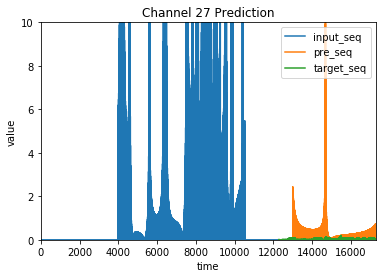

<Figure size 7200x720 with 0 Axes>

In [277]:
           '''Visualization of predicted time series'''
in_seq = reg_data.ix[:,i][endix:endix+w]
tar_seq = reg_data.ix[:,i][endix+w:endix+w+p_w]
predicted_seq = predicted_seq.reshape((p_w))
d = {'time': reg_data.ix[:,i][endix+w:endix+w+p_w], 'values': predicted_seq}
df_sine_pre = pd.DataFrame(data=d)
pre_seq = df_sine_pre['values']

plt.plot(in_seq)
plt.plot(tar_seq)
plt.plot(pre_seq)


plt.ylim(top = 10)
plt.ylim(bottom=0)

plt.title('Channel 27 Prediction')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['input_seq', 'pre_seq', 'target_seq'], loc='upper right')
axes = plt.gca()
axes.set_xlim([endix,endix+w+p_w])
fig_predict = plt.figure(figsize=(100,10))
fig_predict.savefig('predicted_sequence.png')
plt.show()    

In [224]:
'''

            """Predicting random intervals (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('ch_1_weights.h5')
          
# Sample a portion of the raw_seq randomly
# 1. Choose 
ran_ix = random.randint(1,len(raw_seq) - w - p_w)
input_seq = array(raw_seq[ran_ix : ran_ix + w])
target_seq = array(raw_seq[ran_ix + w : ran_ix + w + p_w])
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]
'''

'\n\n            """Predicting random intervals (DeepAnT)"""\n# Build model \nmodel = Sequential()\nmodel.add(Conv1D(filters=num_filt_1,\n                 kernel_size=kernel_size,\n                 strides=conv_strides,\n                 padding=\'valid\',\n                 activation=\'relu\',\n                 input_shape=(w, n_features)))\nmodel.add(MaxPooling1D(pool_size=pool_size_1)) \nmodel.add(Conv1D(filters=num_filt_2,\n                 kernel_size=kernel_size,\n                 strides=conv_strides,\n                 padding=\'valid\',\n                 activation=\'relu\'))\nmodel.add(MaxPooling1D(pool_size=pool_size_2))\nmodel.add(Flatten())\nmodel.add(Dense(units=num_nrn_dl, activation=\'relu\')) \nmodel.add(Dropout(dropout_rate))\nmodel.add(Dense(units=num_nrn_ol))\n\n# Load the model\'s saved weights.\nmodel.load_weights(\'ch_1_weights.h5\')\n          \n# Sample a portion of the raw_seq randomly\n# 1. Choose \nran_ix = random.randint(1,len(raw_seq) - w - p_w)\ninput_seq 

In [39]:
"""
Determins whether a sequence exceeds the threshold for being an anomaly

return boolean value of whether the sequence is an anomaly or not
"""
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    if (dist > anm_det_thr):
        return true  # anomaly
    else:
        return false # normal 